# TOPIC 4: Classical Multi-Armed Bandit → Quantum Decision Model

(Strategic decision making — HIGH VALUE FOR PAPER)

In [1]:
%pip install pennylane pennylane-lightning torch scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


## 4A. Classical Bandit (ε-greedy)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pennylane as qml


In [3]:
N_ARMS = 3
TIME_STEPS = 300

# True reward probabilities (unknown to agents)
ARM_PROBS = [0.2, 0.5, 0.8]

def pull_arm(arm):
    return 1 if np.random.rand() < ARM_PROBS[arm] else 0


In [4]:
metrics_classical = {
    "progress": [],
    "performance": []
}

metrics_quantum = {
    "progress": [],
    "performance": []
}


In [5]:
Q = np.zeros(N_ARMS)
epsilon = 0.1
alpha = 0.1


In [6]:
cumulative_reward = 0

for t in range(TIME_STEPS):

    # ε-greedy action selection
    if np.random.rand() < epsilon:
        action = np.random.randint(N_ARMS)
    else:
        action = np.argmax(Q)

    reward = pull_arm(action)

    # Q-value update
    Q[action] += alpha * (reward - Q[action])

    cumulative_reward += reward

    # 🔴 METRIC COLLECTION (SVM-STYLE)
    metrics_classical["progress"].append(t)
    metrics_classical["performance"].append(cumulative_reward)


## 4B. Quantum Bandit (VQC Policy)

In [7]:
N_QUBITS = 3
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def quantum_policy(state, weights):
    qml.AngleEmbedding(state, wires=range(N_QUBITS))
    qml.BasicEntanglerLayers(weights, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]


In [8]:
weights = torch.nn.Parameter(torch.randn(2, N_QUBITS))
optimizer = torch.optim.Adam([weights], lr=0.1)


In [9]:
cumulative_reward = 0

for t in range(TIME_STEPS):

    # Dummy state (bandit has no true state)
    state = torch.rand(N_QUBITS)

    logits = torch.stack(quantum_policy(state, weights))
    probs = torch.softmax(logits, dim=0)

    action = torch.multinomial(probs, 1).item()
    reward = pull_arm(action)

    # Policy gradient–style update
    loss = -torch.log(probs[action]) * reward

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    cumulative_reward += reward

    # 🔴 METRIC COLLECTION (MATCHES CLASSICAL)
    metrics_quantum["progress"].append(t)
    metrics_quantum["performance"].append(cumulative_reward)


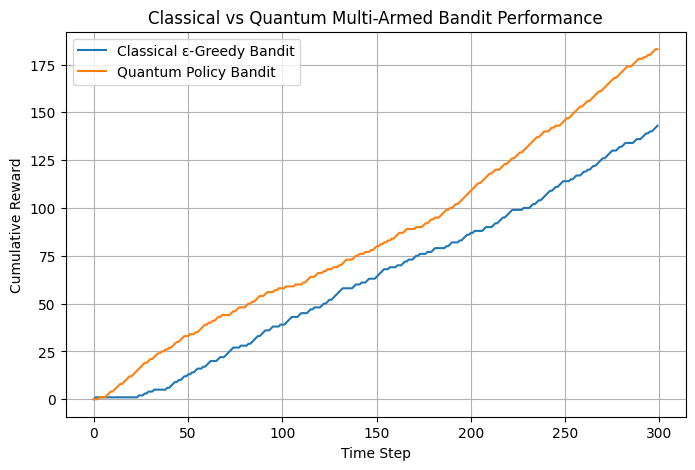

In [10]:
plt.figure(figsize=(8, 5))

plt.plot(
    metrics_classical["progress"],
    metrics_classical["performance"],
    label="Classical ε-Greedy Bandit"
)

plt.plot(
    metrics_quantum["progress"],
    metrics_quantum["performance"],
    label="Quantum Policy Bandit"
)

plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.title("Classical vs Quantum Multi-Armed Bandit Performance")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
results = pd.DataFrame({
    "Model": ["Classical Bandit", "Quantum Bandit"],
    "Total Reward": [
        metrics_classical["performance"][-1],
        metrics_quantum["performance"][-1]
    ],
    "Average Reward per Step": [
        metrics_classical["performance"][-1] / TIME_STEPS,
        metrics_quantum["performance"][-1] / TIME_STEPS
    ]
})

results


,Model,Total Reward,Average Reward per Step
0,Classical Bandit,143,0.476667
1,Quantum Bandit,183,0.610000


**Paper framing:**
“Quantum policies model strategic decisions via entangled action representations.”